In [2]:
import os
import sys
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.stats
import tqdm

import util_figures
import util_stimuli

sys.path.append("bez2018model")
import bez2018model

dir_fig = "figures_revision1"


In [3]:
"""
Load auditory nerve model parameters
"""
fn_bez2018model_config = "stimuli/spkr_word_recognition/optimization/valid/tfrecords_IHC3000/config.json"
with open(fn_bez2018model_config, "r") as f:
    bez2018model_config = json.load(f)
kwargs_nervegram = bez2018model_config["kwargs_ExampleProcessor"]["kwargs_nervegram"]


In [4]:
"""
Load example stimulus (2-second speech utterance)
"""
fn = "stimuli/spkr_word_recognition/evaluation/human_experiment_v00_foreground60dbspl/stim.hdf5"
index = -1
with h5py.File(fn, "r") as f:
    y = f["signal"][index]
    y_sr = f["sr"][index]

ipd.display(ipd.Audio(rate=y_sr, data=y))


In [5]:
"""
Run auditory nerve model to obtain instantaneous firing rate representation
"""
out = bez2018model.nervegram(y, y_sr, **kwargs_nervegram)
for k in out.keys():
    v = np.array(out[k])
    print("|__ {} : {}".format(k, (v, v.dtype) if v.ndim == 0 else (v.shape, v.dtype)))


|__ signal : ((40000,), dtype('float32'))
|__ signal_fs : (array(20000), dtype('int64'))
|__ pin : ((200000,), dtype('float32'))
|__ pin_fs : (array(100000.), dtype('float64'))
|__ nervegram_fs : (array(10000.), dtype('float64'))
|__ nervegram_dur : (array(2.), dtype('float64'))
|__ nervegram_spike_tensor_fs : (array(100000.), dtype('float64'))
|__ cf_list : ((50,), dtype('float32'))
|__ bandwidth_scale_factor : ((50,), dtype('float32'))
|__ species : (array(2), dtype('int64'))
|__ spont : ((3,), dtype('float64'))
|__ buffer_start_dur : (array(0.), dtype('float64'))
|__ buffer_end_dur : (array(0.), dtype('float64'))
|__ pin_dBSPL_flag : (array(0), dtype('int64'))
|__ pin_dBSPL : (array(60.00342675), dtype('float64'))
|__ synapseMode : (array(0), dtype('int64'))
|__ max_spikes_per_train : (array(1000), dtype('int64'))
|__ num_spike_trains : (array(1), dtype('int64'))
|__ cohc : ((50,), dtype('float64'))
|__ cihc : ((50,), dtype('float64'))
|__ IhcLowPass_cutoff : (array(3000), dtype('in

In [6]:
"""
Sample auditory nerve fiber spike trains with and without refractoriness
"""
refractory_period = 1e-3 # 1-millisecond absolute refractory period
anf_per_channel = [384, 160, 96]

dict_to_plot = {}
all_spikes = []
all_spikes_refractory = []
for index_spont, key in enumerate(["HSR", "MSR", "LSR"]):
    spont = out["spont"][index_spont]
    n = anf_per_channel[index_spont]
    rates = out["nervegram_meanrates"][:, :, index_spont]
    rates_sr = out["nervegram_fs"]
    refractory_samples = int(refractory_period * rates_sr)
    prob = rates / rates_sr
    # Binomial spike sampling (ignores refractory effects)
    spikes = np.random.rand(*([n] + list(prob.shape))) < prob[None, ...]
    spikes = spikes.astype(int)
    # Introduce refractoriness by iterating ove time samples and eliminating spikes during refractory period
    spikes_refractory = spikes.copy().reshape(-1, spikes.shape[-1])
    t_max = spikes.shape[-1]
    for t in tqdm.tqdm(range(0, t_max)):
        SPIKED_AT_T = spikes_refractory[:, t] > 0
        spikes_refractory[SPIKED_AT_T, t + 1 : min(t_max, t + refractory_samples)] = 0
    spikes_refractory = spikes_refractory.reshape(spikes.shape)
    spikes = spikes.sum(axis=0)
    spikes_refractory = spikes_refractory.sum(axis=0)
    dict_to_plot[key] = {
        "sr": rates_sr,
        "rates": rates,
        "spikes": spikes,
        "spikes_refractory": spikes_refractory,
    }
    all_spikes.append(spikes)
    all_spikes_refractory.append(spikes_refractory)
all_spikes = np.stack(all_spikes, axis=0)
all_spikes_refractory = np.stack(all_spikes_refractory, axis=0)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 28425.84it/s]


In [7]:
"""
Summarize how many fewer spikes are sampled when refractoriness is considered
"""
print("Total spikes ignoring refractoriness: {}".format(all_spikes.sum()))
print("Total spikes with {} ms refractory period: {}".format(1e3 * refractory_period, all_spikes_refractory.sum()))
print("Reduction in spikes: {:.2f}% overall".format(
    100 * (1 - all_spikes_refractory.sum() / all_spikes.sum())))
print("Reduction in spikes: {:.2f}% HSR {:.2f}% MSR, {:.2f}% LSR".format(
    *100 * (1 - np.sum(all_spikes_refractory, axis=(1, 2)) / np.sum(all_spikes, axis=(1, 2)))))


Total spikes ignoring refractoriness: 3230710
Total spikes with 1.0 ms refractory period: 2998598
Reduction in spikes: 7.18% overall
Reduction in spikes: 7.51% HSR 5.64% MSR, 2.76% LSR


Non-refractory vs. refractory (HSR): r=0.991719, r2=0.983506, p=0.0
Non-refractory vs. refractory (MSR): r=0.995983, r2=0.991983, p=0.0
Non-refractory vs. refractory (LSR): r=0.995107, r2=0.990237, p=0.0


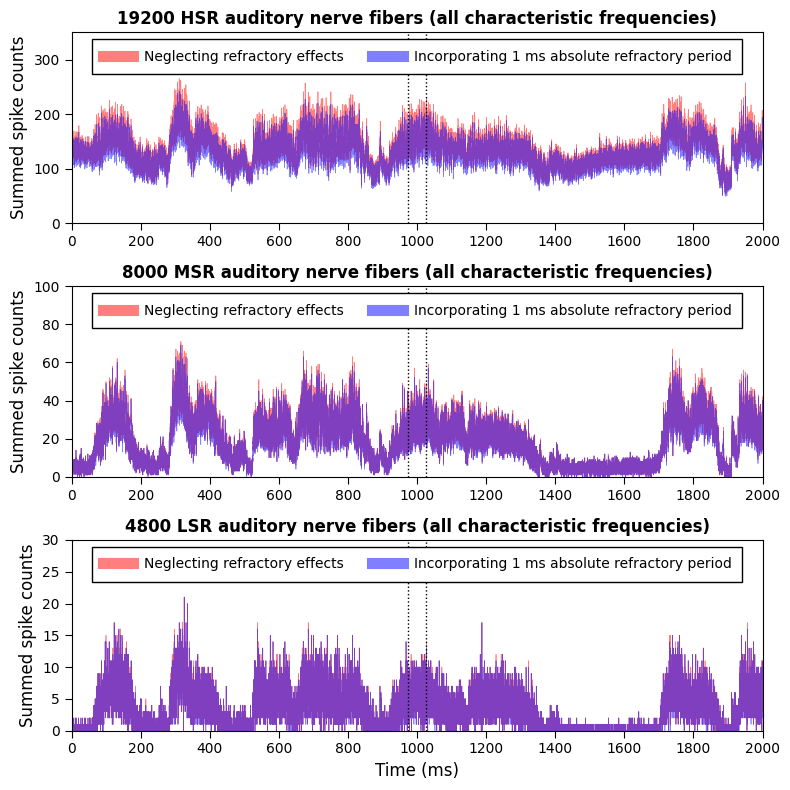

### WROTE: figures_revision1/refractory_analysis_2000ms.pdf ###
Non-refractory vs. refractory (HSR): r=0.991719, r2=0.983506, p=0.0
Non-refractory vs. refractory (MSR): r=0.995983, r2=0.991983, p=0.0
Non-refractory vs. refractory (LSR): r=0.995107, r2=0.990237, p=0.0


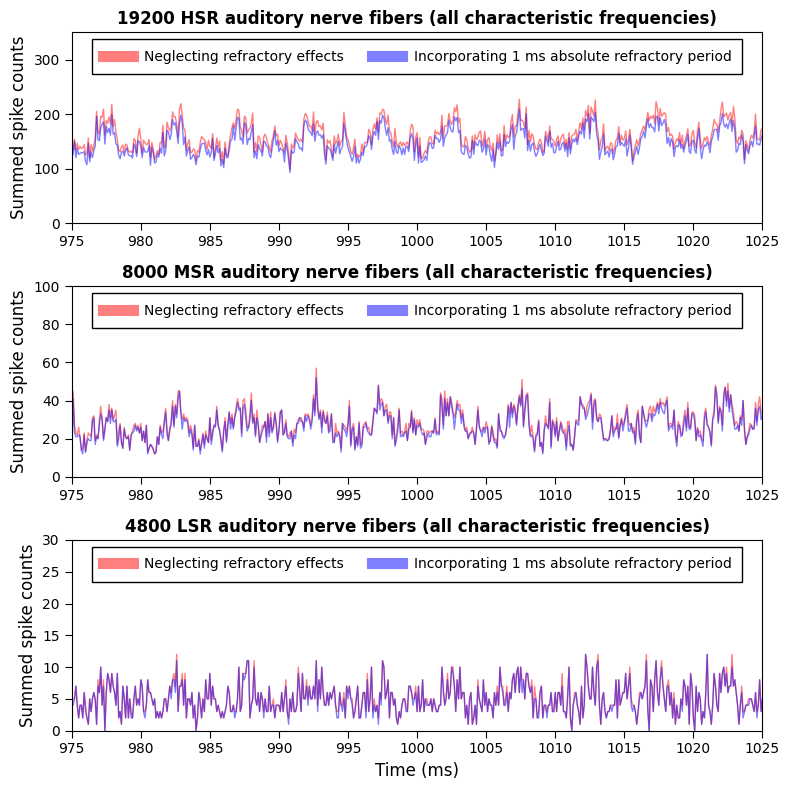

### WROTE: figures_revision1/refractory_analysis_50ms.pdf ###


In [17]:
"""
Visualize the difference between incorporating vs. ignoring
refractoriness in the summed spike counts
"""
list_xlimits = [[0, 2e3], [975, 1025]]
for xlimits in list_xlimits:
    for index_freq in [
        None,
    ]:
        if index_freq is not None:
            cf = out["cf_list"][index_freq]
            print(f"ANFs at CF: {cf}")
        fig, ax_arr = plt.subplots(
            figsize=(8, 8),
            nrows=len(dict_to_plot),
            ncols=1,
        )
        for itr_ax, key in enumerate(dict_to_plot.keys()):
            ax = ax_arr[itr_ax]
            spikes = dict_to_plot[key]["spikes"]
            spikes_refractory = dict_to_plot[key]["spikes_refractory"]
            t = np.arange(spikes.shape[-1]) / dict_to_plot[key]["sr"]
            kwargs_plot = {
                "lw": 0.5 if xlimits[0] == 0 else 1,
                "color": "r",
                "alpha": 0.5,
                "label": "Neglecting refractory effects",
            }
            kwargs_plot_refractory = {
                "lw": 0.5 if xlimits[0] == 0 else 1,
                "color": "b",
                "alpha": 0.5,
                "label": "Incorporating {:.0f} ms absolute refractory period".format(1e3 * refractory_period),
            }
            if index_freq is not None:
                str_title = "{} {} auditory nerve fibers with CF = {:.0f} Hz".format(anf_per_channel[itr_ax], key, cf)
                ax.plot(1e3 * t, spikes[index_freq], **kwargs_plot)
                ax.plot(1e3 * t, spikes_refractory[index_freq], **kwargs_plot_refractory)
                r, p = scipy.stats.pearsonr(spikes[index_freq], spikes_refractory[index_freq])
            else:
                str_title = "{} {} auditory nerve fibers (all characteristic frequencies)".format(
                    anf_per_channel[itr_ax] * spikes.shape[0], key)
                ax.plot(1e3 * t, spikes.sum(axis=0), **kwargs_plot)
                ax.plot(1e3 * t, spikes_refractory.sum(axis=0), **kwargs_plot_refractory)
                r, p = scipy.stats.pearsonr(spikes.sum(axis=0), spikes_refractory.sum(axis=0))
            print("Non-refractory vs. refractory ({}): r={:.6f}, r2={:.6f}, p={}".format(key, r, r ** 2, p))
            leg = ax.legend(
                ncols=2,
                frameon=True,
                fancybox=False,
                facecolor="w",
                edgecolor="k",
                framealpha=1,
                loc="upper center",
                borderaxespad=0.5,
                borderpad=0.75,
                handlelength=2.2,
            )
            for line in leg.get_lines():
                line.set_linewidth(8.0)
            ax = util_figures.format_axes(
                ax,
                xlimits=xlimits,
                xticks=np.linspace(*xlimits, 11),
                ylimits=[0, [350, 100, 30][itr_ax]] if index_freq is None else None,
                str_xlabel="Time (ms)" if itr_ax == 2 else None,
                str_ylabel="Summed spike counts",
                str_title=str_title,
                fontsize_ticks=10,
                fontweight_title="bold",
            )
            if xlimits[0] == 0:
                ax.axvline(list_xlimits[1][0], lw=1, color="k", ls=":")
                ax.axvline(list_xlimits[1][1], lw=1, color="k", ls=":")
        plt.tight_layout()
        plt.show()

        fn_fig = "refractory_analysis_{}ms.pdf".format(int(xlimits[1] - xlimits[0]))
        fn_fig = os.path.join(dir_fig, fn_fig)
        fig.savefig(fn_fig, bbox_inches="tight", pad_inches=0.05, transparent=False)
        print(f"### WROTE: {fn_fig} ###")
